# **EDA Images**

**Course:** Master in Big Data, Data Science & AI — Master Thesis  
**Author:** Carlota Trigo La Blanca  

*This notebook will be used to do the exploratory data analysis of the images from the database developed for my Master Thesis. The variables analyzed are those extracted from the images themselves.*

## **Initialization**

In [8]:
# pip install -q pandas pillow matplotlib fsspec gcsfs  # <- uncomment if needed

In [9]:
from google.colab import auth
auth.authenticate_user()

In [10]:
import math
import pandas as pd
import fsspec
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import os
import fsspec  # requiere gcsfs instalado para gs://

In [15]:
# --- CONFIG ---
METADATA_CSV = "gs://ucm_tfm_datos_carlotatrigo/metadata_clean.csv"
df = pd.read_csv(METADATA_CSV)

IMAGES_BASE = "gs://ucm_tfm_datos_carlotatrigo/images/images"  # <-- your bucket/prefix

### Visualize an image per diagnostic

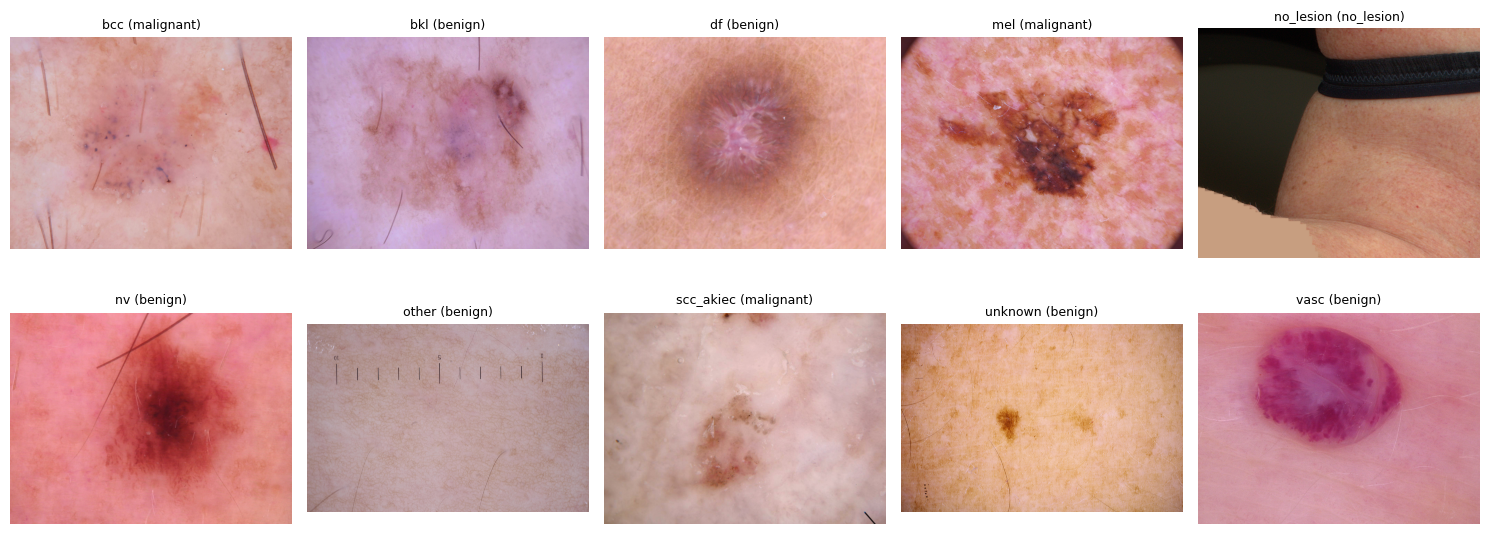

In [31]:
def build_uri(row):
    return f"{IMAGES_BASE}/{row.get("image_id")}"

def open_image_any(uri):
    """Abre imagen desde gs:// o ruta local y respeta orientación EXIF."""
    try:
        s = str(uri)
        if s.startswith("gs://"):
            with fsspec.open(s, "rb") as f:
                data = f.read()
            im = Image.open(io.BytesIO(data)).convert("RGB")
        else:
            im = Image.open(s).convert("RGB")
        return ImageOps.exif_transpose(im)
    except Exception as e:
        return None  # si falla, lo señalamos en el subplot

# Prepara una muestra: 1 fila representativa por diagnosis_grouped
# df = pd.read_csv(METADATA_CSV)
tmp = df.dropna(subset=["diagnosis_grouped"]).copy()
tmp["img_uri"] = tmp.apply(build_uri, axis=1)

reps = (tmp.sort_values(["diagnosis_grouped", "origin_dataset", "image_id"])
           .groupby("diagnosis_grouped", as_index=False)
           .nth(0)
           .reset_index(drop=True))

n = len(reps)
if n == 0: raise ValueError("No hay imágenes con diagnosis_grouped.")

ncols = min(5, max(1, n))
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(3.0*ncols, 3.0*nrows))
axes = np.atleast_1d(axes).ravel()

for ax, (_, row) in zip(axes, reps.iterrows()):
    ax.axis("off")
    im = open_image_any(row["img_uri"])
    title = f"{row['diagnosis_grouped']} ({row['lesion_type']})"
    if im is None:
        ax.text(0.5, 0.5, "No se pudo abrir", ha="center", va="center", fontsize=9)
        ax.set_title(title, fontsize=9)
        continue
    ax.imshow(im)
    ax.set_title(title, fontsize=9)

# Apaga ejes sobrantes si la rejilla es mayor que n
for ax in axes[len(reps):]:
    ax.axis("off")

plt.tight_layout()
plt.show()